### Neural Nets from Scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

np.random.seed(42)

### Utils

In [22]:
def sigma(x):
    return 1 / (1 + np.exp(-x))


def sigma_prime(x):
    return sigma(x) * (1 - sigma(x))

def perceptron_activation(x):
    if x > 0: return 1
    else: return 0

def error():
    pass

### Network Class

In [70]:
class Network:

    def __init__(self, num_layers, layer_sizes, learning_rate=0.05):
        self.num_layers = num_layers
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.input_size = layer_sizes[-1]
        self.weight_matrices = [
            np.random.rand(layer_sizes[i + 1], layer_sizes[i])
            for i in range(num_layers - 1)
        ]
        self.bias_vectors = [
            np.random.rand(layer_sizes[i + 1], 1) for i in range(num_layers - 1)
        ]
        self.layer_inputs = [
            np.zeros((layer_sizes[i + 1], 1)) for i in range(num_layers - 1)
        ]
        self.layer_activations = [
            sigma(self.layer_inputs[i]) for i in range(num_layers - 1)
        ]

        self.errors = [np.zeros((layer_sizes[i + 1], 1)) for i in range(num_layers - 1)]

        self.grad_weights = [
            np.zeros((layer_sizes[i + 1], layer_sizes[i]))
            for i in range(num_layers - 1)
        ]
        self.grad_bias = [
            np.zeros((layer_sizes[i + 1], 1)) for i in range(num_layers - 1)
        ]

    def forward_pass(self, x, y):
        """
        Does a forward pass to update the inputs (z) and outputs (a) for each layer. We also get the gradients and errors of the last layer.
        :param x: A 2 element list/numpy_array
        :param y: A 1D integer label
        :return: A 1D np.float activation of the final layer
        """
        # computes neuron activations for a single input
        x = np.array(x).reshape(-1, 1)
        if x.shape[0] != self.layer_sizes[0]:
            raise ValueError(
                f"Input array shape {x.shape} does not match network input size {self.layer_sizes[0]}"
            )

        a = x
        i = 0
        for w, b in zip(self.weight_matrices, self.bias_vectors):
            z = np.dot(w, a) + b
            a = sigma(z)
            self.layer_inputs[i] = z
            self.layer_activations[i] = a
            i += 1

        if y == 1:
            self.errors[-1] = (-1 / self.layer_activations[-1]) * sigma_prime(self.layer_inputs[-1])
        else:
            self.errors[-1] = (1 / (1 - self.layer_activations[-1])) * sigma_prime(self.layer_inputs[-1]) #dC/dzj = dC/da * da/dzj = dC/da * sigma'(zj) = -1 * - 1/(1-y_hat)

        self.grad_weights[-1] += np.dot(self.errors[-1], self.layer_activations[-2].T)
        self.grad_bias[-1] += self.errors[-1]

        return self.layer_activations[-1][0][0]

    def backward_pass(self, x):
        """
        Computes the errors and gradients of each of the weights and biases layer by layer from the last layer to the first layer.
        :param x: A 2 element list/numpy_array, the input instance, this is required to compute the gradient for first layer, as activation for first layer is the input x itself.
        :return: None
        """
        # computes gradients of paramaters for every weight link
        for i in range(-2, -self.num_layers, -1):
            self.errors[i] = np.dot( self.weight_matrices[i + 1].T, self.errors[i + 1]) * sigma_prime(self.layer_inputs[i + 1])
            if i != (-self.num_layers + 1): #the first input layer does not have any activation, the activation is the input x. Therefore, the formula is different, and we update it separately outside the loop.
                self.grad_weights.appendleft(np.dot(self.errors[i], self.layer_activations[i - 1].T)) # since we are doing the backward pass, we have to append left to get the errors in the same order as layers
            self.grad_bias[i] += self.errors[i]
        self.grad_weights[i] += np.dot(self.errors[0], np.array(x).reshape(-1, 1).T)
        return None

    # def fit(self, X, y, epochs=500):
    #     pass

    def predict(self):
        pass

    def update_weights(self):
        """updates the weights of the network as w = w - alpha*grad_w"""
        self.weight_matrices = [
            self.weight_matrices[i] - self.learning_rate * self.grad_weights[i]
            for i in range(self.num_layers - 1) #num_layers - 1 as the number of weight matrices is one less than the number of layers
        ]
        self.bias_vectors = [
            self.bias_vectors[i] - self.learning_rate * self.grad_bias[i]
            for i in range(self.num_layers - 1)
        ]

    def compute_error(self, y_hat, y):
        """Computes the cross entropy error for single data instance."""
        return -y * np.log(y_hat) - (1 - y) * np.log(1-y_hat)

    def fit(self, X, Y, verbose =True, epochs = 10):

        errors = {}
        for i in range(epochs):
            for x, y in zip(X, Y):
                if verbose:
                    # print("Initial Parameters: \n")
                    # self.display_params()
                    y_hat = self.forward_pass(x=x, y=y)
                    print("\nForward Pass yields: ", y_hat)
                    # print ("\nLayer Activation: \n", self.layer_activations)
                    # print("\nLayer Inputs: \n", self.layer_inputs)
                    print("Model Error: \n", self.compute_error(y_hat, y))
                    self.backward_pass([1, 1])
                    # print("\nLayer Errors: \n", self.errors)
                    # print("\nLayer Grad_Weights: \n", self.grad_weights)
                    self.update_weights()
                    # print("Updated Weights: \n", self.weight_matrices)
                    y_hat_updated = self.forward_pass(x=x, y=y)
                    print("\nForward Pass yields: ", y_hat_updated)
                    print("Model Error after updation: ", self.compute_error(y_hat_updated, y))
                else:
                    y_hat = self.forward_pass(x=x, y=y)
                    print("\nForward Pass yields: ", y_hat)
                    print("Model Error:", self.compute_error(y_hat, y))
                    self.backward_pass(x)
                    self.update_weights()
                    y_hat_updated = self.forward_pass(x=x, y=y)
                    print("\nForward Pass yields: ", y_hat_updated)
                    print("Model Error after updation: ", self.compute_error(y_hat_updated, y))
                errors[i] = errors.get(i, 0) + self.compute_error(y_hat_updated, y)
        return errors


    def display_params(self):
        print("Network Architecture: ", self.layer_sizes)
        for i in range(self.num_layers - 1):
            print(
                "Weight matrix of Layer ",
                i,
                " has shape:",
                self.weight_matrices[i].shape,
            )
            print(self.weight_matrices[i])
            print("Bias of Layer ", i)
            print(self.bias_vectors[i])


    def display_activations(self):
        print("Network Architecture: ", self.layer_sizes)
        for i in range(self.num_layers - 1):
            print("Activations of Layer ", i)
            print(self.layer_activations[i])

### Testing

In [71]:
model = Network(num_layers=3, layer_sizes=(2, 4, 1))
x_train = [[1,1]]
y_train = [0]
errors = model.fit(x_train, y_train, verbose =False, epochs =10)


Forward Pass yields:  0.9593560336720821
Model Error: 3.202904883822631

Forward Pass yields:  0.9515326056695996
Model Error after updation:  3.026863988968889

Forward Pass yields:  0.9515326056695996
Model Error: 3.026863988968889

Forward Pass yields:  0.9190715117281842
Model Error after updation:  2.514189375102644

Forward Pass yields:  0.9190715117281842
Model Error: 2.514189375102644

Forward Pass yields:  0.8225207188719139
Model Error after updation:  1.7289014029186325

Forward Pass yields:  0.8225207188719139
Model Error: 1.7289014029186325

Forward Pass yields:  0.5814660417542616
Model Error after updation:  0.8709972495828819

Forward Pass yields:  0.5814660417542616
Model Error: 0.8709972495828819

Forward Pass yields:  0.2519281488086152
Model Error after updation:  0.2902562478784162

Forward Pass yields:  0.2519281488086152
Model Error: 0.2902562478784162

Forward Pass yields:  0.0696573125939831
Model Error after updation:  0.072202279625578

Forward Pass yields: 

In [72]:
errors

{0: np.float64(3.026863988968889),
 1: np.float64(2.514189375102644),
 2: np.float64(1.7289014029186325),
 3: np.float64(0.8709972495828819),
 4: np.float64(0.2902562478784162),
 5: np.float64(0.072202279625578),
 6: np.float64(0.016221241895211177),
 7: np.float64(0.0035745764636471713),
 8: np.float64(0.0007896429558439225),
 9: np.float64(0.0001757533462378141)}

### XOR Training instance

In [74]:
x_train = [[0,0], [0,1], [1,0], [1,1]]
y_train = [0,1,1,0]

model = Network(num_layers=3, layer_sizes=(2, 4, 1))
errors = model.fit(x_train, y_train, verbose =False, epochs =10)



Forward Pass yields:  0.8314698802898239
Model Error: 1.7806407931747785

Forward Pass yields:  0.815201966151159
Model Error after updation:  1.6884917591772501

Forward Pass yields:  0.8304373851891855
Model Error: 0.18580274688402793

Forward Pass yields:  0.7984463521694019
Model Error after updation:  0.2250874993456849

Forward Pass yields:  0.7873093140538062
Model Error: 0.23913407848724166

Forward Pass yields:  0.7618047408157462
Model Error after updation:  0.2720650017806436

Forward Pass yields:  0.7757829475896897
Model Error: 1.49514071231442

Forward Pass yields:  0.7283386572930203
Model Error after updation:  1.3031990519990362

Forward Pass yields:  0.7171524523518887
Model Error: 1.2628472273804212

Forward Pass yields:  0.622783773507964
Model Error after updation:  0.9749367108765244

Forward Pass yields:  0.6278690389711478
Model Error: 0.46542367093088005

Forward Pass yields:  0.5066015373630081
Model Error after updation:  0.6800305067507735

Forward Pass yie

### Visualising Manufactured data

In [4]:
def generate_data():
    x = np.linspace(0, 50, 4000)
    y = 0.2 + 0.4 * (x**2) + 0.3 * np.sin(15 * x) + 0.05 * np.cos(50 * x)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Classifier Line", color="blue")

    # if show_plot:
    #     plot(data, labels, weights = orig_weights, bias = orig_bias)

    return x, y

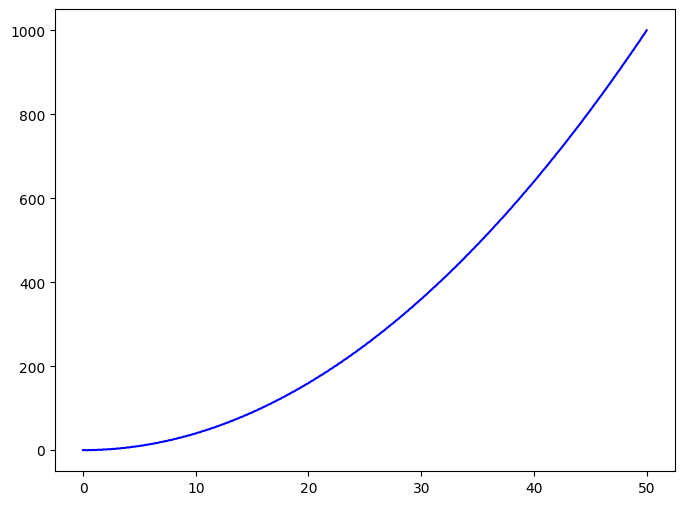

In [5]:
x, y = generate_data()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 22.0M/22.0M [00:05<00:00, 3.99MB/s]

Extracting files...


Path to dataset files: C:\Users\260005143\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [1]:
from mlxtend.data import loadlocal_mnist
import pandas as pd
import os
import random

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from os.path import join
import struct
from array import array


class MnistDataloader(object):
    def __init__(
        self,
        training_images_filepath,
        training_labels_filepath,
        test_images_filepath,
        test_labels_filepath,
    ):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, "rb") as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    "Magic number mismatch, expected 2049, got {}".format(magic)
                )
            labels = array("B", file.read())

        with open(images_filepath, "rb") as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    "Magic number mismatch, expected 2051, got {}".format(magic)
                )
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols : (i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath
        )
        x_test, y_test = self.read_images_labels(
            self.test_images_filepath, self.test_labels_filepath
        )
        return (x_train, y_train), (x_test, y_test)


# Set file paths based on added MNIST Datasets
training_images_filepath = "/kaggle/input/mnist-dataset/train-images.idx3-ubyte"
training_labels_filepath = "/kaggle/input/mnist-dataset/train-labels.idx1-ubyte"
test_images_filepath = "/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte"
test_labels_filepath = "/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte"


# Load MINST dataset
print("Loading MNIST dataset...")
mnist_dataloader = MnistDataloader(
    training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath,
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print("MNIST dataset loaded.")


# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != "":
            plt.title(title_text, fontsize=15)
        index += 1


random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append(
        (x_train[r], "training image [" + str(r) + "] = " + str(y_train[r]))
    )
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], "test image [" + str(r) + "] = " + str(y_test[r])))

show_images(
    list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images))
)

Loading MNIST dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'